In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mnist_means(kmc):
    f, (ax0, ax1, ax2) = plt.subplots(figsize=(10,32),ncols=3)
    axeslist = [ax0,ax1,ax2]
    for i in range(3):
        ax = axeslist[i]
        ax.set_title("count = {}".format(kmc.n_per_cluster[i]))
        ax.imshow(kmc.cluster_centers_[i].reshape(28,28),cmap='Greys')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    plt.show()


In [2]:
from sparseklearn import load_mnist_dataset

np.random.seed(27)
X_train, y_train, X_test, y_test = load_mnist_dataset()

# KMeans clustering

In [3]:
from sparseklearn import KMeans

First let's just fit the training data with all the default options. The only parameters we need to specify are the compression factor (gamma) and the number of clusters. Here's what the means look like for the given training data.

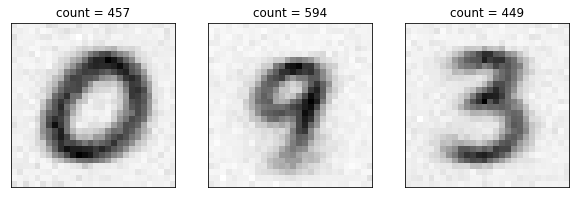

In [26]:
kmc = KMeans(gamma = 0.1, n_clusters = 3)
kmc.fit(X_train)
plot_mnist_means(kmc)

They look a lot cleaner if we use the two-pass algorithm instead of the one-pass. The two-pass algorithm reconstructs the means from the dense training data.

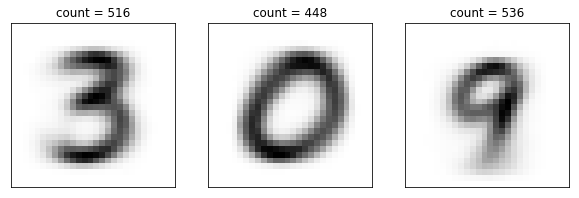

In [27]:
kmc = KMeans(gamma = .1, n_clusters = 3, n_passes = 2)
kmc.fit(X_train)
plot_mnist_means(kmc)

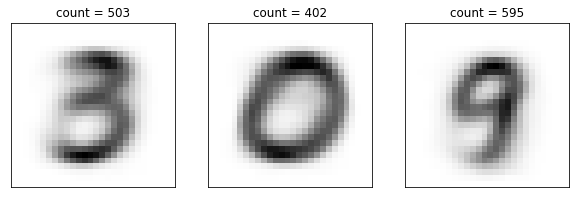

In [28]:
kmc = KMeans(gamma = 12, alpha = 3, n_init = 50, n_clusters = 3, n_passes = 2)
kmc.fit(X_train)
plot_mnist_means(kmc)